## PREDICTING DISPOSITION DESTINATION IN HOSPITALIZED STROKE PATIENTS

### Introduction

Patients hospitalized with acute stroke frequently require referrals to rehabilitation, some of which require few social work referrals and arrangements, whereas some require many that can significantly increase hospital length of stay. From the hospital’s and stroke neurologist’s perspective, there is therefore a need to identify which patients need which types of rehabilitation early on in their hospital course so as to remove bottlenecks to patient throughput.

### Objective
In the first 24 hours of a stroke patient’s admission (including time spent in the emergency department), accurately predict the likelihood of discharge to specific disposition destinations.

### Data cleaning and exploration

In [181]:
import pandas as pd
# load medical charge summaries as DataFrame with pandas
admission_data = pd.read_csv('ADMISSIONS.csv')
# check the loaded data
print 'There are %d rows and %d columns in the note events table.'%(admission_data.shape[0], admission_data.shape[1])
admission_data.head()

There are 58976 rows and 19 columns in the note events table.


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


#### Remove rows with missing hospital addimission ID (HADM_ID) if there is any

In [3]:
for col in admission_data.columns:
    print 'The number of NULL values in column %s is %d'%(col, sum(pd.isnull(admission_data[col])))

The number of NULL values in column ROW_ID is 0
The number of NULL values in column SUBJECT_ID is 0
The number of NULL values in column HADM_ID is 0
The number of NULL values in column ADMITTIME is 0
The number of NULL values in column DISCHTIME is 0
The number of NULL values in column DEATHTIME is 53122
The number of NULL values in column ADMISSION_TYPE is 0
The number of NULL values in column ADMISSION_LOCATION is 0
The number of NULL values in column DISCHARGE_LOCATION is 0
The number of NULL values in column INSURANCE is 0
The number of NULL values in column LANGUAGE is 25332
The number of NULL values in column RELIGION is 458
The number of NULL values in column MARITAL_STATUS is 10128
The number of NULL values in column ETHNICITY is 0
The number of NULL values in column EDREGTIME is 28099
The number of NULL values in column EDOUTTIME is 28099
The number of NULL values in column DIAGNOSIS is 25
The number of NULL values in column HOSPITAL_EXPIRE_FLAG is 0
The number of NULL values 

In [9]:
# change data type of HADM_ID to be integer
admission_data['DIAGNOSIS'] = admission_data['DIAGNOSIS'].astype('str')

#### Identify stroke patients with text in DIAGNOSIS, not complete, changed to ICD-9 code later

In [16]:
admission_data['is_stroke'] = admission_data.apply(lambda row: 1 if row['DIAGNOSIS'].find('STROKE')>=0 else 0, axis=1)
admission_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,is_stroke
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,0


In [17]:
admission_data['is_stroke'].value_counts()

0    58140
1      836
Name: is_stroke, dtype: int64

#### Identify stroke patients with ICD-9 code

In [7]:
# load ICD9 diagnosis code table into pandas dataframe
file_name = 'DIAGNOSES_ICD.csv'
codes_data = pd.read_csv(file_name)
# examine the diagnosis table
print 'There are %d rows %d and columns in the diagnosis code table.'\
        %(codes_data.shape[0], codes_data.shape[1])
codes_data.head()

There are 651047 rows 5 and columns in the diagnosis code table.


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


 In mentor feedback, they mentioned "... define “stroke” as “ischemic stroke” only, which is the most common type of storke", starting with "434" and 1480 data points found

In [24]:

codes_data['ICD9_CODE'] = codes_data['ICD9_CODE'].astype('str')
codes_data['is_stroke'] = codes_data.apply(lambda row: 1 if row['ICD9_CODE'][:3]=='434' else 0, axis=1)

In [25]:
codes_data['is_stroke'].value_counts()

0    649567
1      1480
Name: is_stroke, dtype: int64

#### remove data of non-stroke patients

In [45]:
stroke_codes_data = codes_data[codes_data['is_stroke'] != 0]
stroke_codes_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,is_stroke
1474,3010,249,149546,3.0,43411,1
2154,3690,308,166606,8.0,43491,1
2174,3710,313,199765,3.0,43491,1
2280,1784,141,168006,2.0,43491,1
3960,5500,454,182153,1.0,43411,1


#### removed unused columns joined two tables

In [46]:

# drop unused columns
stroke_codes_data.drop(['is_stroke', 'ICD9_CODE'], axis = 1, inplace = True)
# merge diagnosis code dictionary table to note events/diagnosis code table
stroke_data = pd.merge(admission_data, stroke_codes_data, on = ['SUBJECT_ID', 'HADM_ID'], how = 'inner')

# examine the joined table
stroke_data.head()

/Users/xu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,is_stroke,ROW_ID_y,SEQ_NUM
0,190,141,168006,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,0,1784,2.0
1,394,308,166606,2135-09-02 23:07:00,2135-10-20 11:53:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Medicaid,...,SINGLE,UNKNOWN/NOT SPECIFIED,2135-09-02 13:18:00,2135-09-03 12:00:00,DILANTIN TOXICITY-MENTAL STATUS CHANGES,0,1,0,3690,8.0
2,398,313,199765,2139-07-26 16:43:00,2139-08-09 15:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,LONG TERM CARE HOSPITAL,Medicare,...,NaN,UNKNOWN/NOT SPECIFIED,2139-07-26 15:42:00,2139-07-26 21:08:00,C7 FRACTURE,0,1,0,3710,3.0
3,421,330,197569,2133-02-27 12:30:00,2133-03-24 17:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Private,...,SINGLE,WHITE,NaN,NaN,LEFT CAROTID STENOSIS/SDA,0,1,0,3895,6.0
4,445,352,121050,2144-05-17 15:47:00,2144-05-21 11:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,SEPARATED,WHITE,2144-05-17 10:54:00,2144-05-17 16:03:00,STROKE;TELEMETRY,0,1,1,4101,1.0


### Feature Engineering
First selected 3 columns for a simple model

In [166]:
X= stroke_data[['ADMISSION_TYPE', 'INSURANCE', 'SEQ_NUM']]
X.head()

,ADMISSION_TYPE,INSURANCE,SEQ_NUM
0,EMERGENCY,Medicare,2.0
1,EMERGENCY,Medicaid,8.0
2,EMERGENCY,Medicare,3.0
3,ELECTIVE,Private,6.0
4,EMERGENCY,Medicare,1.0


In [167]:
stroke_data['SEQ_NUM'].mean()

2.6317567567567566

In [168]:
stroke_data['ADMISSION_TYPE'].value_counts()

EMERGENCY    1362
ELECTIVE       87
URGENT         31
Name: ADMISSION_TYPE, dtype: int64

#### use one-hot encoding on categorical data

In [169]:
X['EMERGENCY'] = X.apply(lambda row: 1 if row['ADMISSION_TYPE'] == 'EMERGENCY' else 0, axis = 1)
X['ELECTIVE'] = X.apply(lambda row: 1 if row['ADMISSION_TYPE'] == 'ELECTIVE' else 0, axis = 1)
X['URGENT'] = X.apply(lambda row: 1 if row['ADMISSION_TYPE'] == 'URGENT' else 0, axis = 1)
X.head()
X.drop(['ADMISSION_TYPE'],axis=1, inplace=True)

/Users/xu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/xu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/xu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### the same trick for coding insurance type

In [170]:
stroke_data['INSURANCE'].value_counts()

Medicare      950
Private       385
Medicaid      110
Government     24
Self Pay       11
Name: INSURANCE, dtype: int64

In [171]:
X['Medicare'] = X.apply(lambda row: 1 if row['INSURANCE'] == 'Medicare' else 0, axis = 1)
X['Private'] = X.apply(lambda row: 1 if row['INSURANCE'] == 'Private' else 0, axis = 1)
X['Medicaid'] = X.apply(lambda row: 1 if row['INSURANCE'] == 'Medicaid' else 0, axis = 1)
X['Government'] = X.apply(lambda row: 1 if row['INSURANCE'] == 'Government' else 0, axis = 1)
X['SelfPay'] = X.apply(lambda row: 1 if row['INSURANCE'] == 'Self Pay' else 0, axis = 1)
X.head()
X.drop(['INSURANCE'],axis=1, inplace=True)

/Users/xu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/xu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/xu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### The output to be predicted has many categories and a long trailing tail. Bin them into five groups

In [172]:
stroke_data['DISCHARGE_LOCATION'].value_counts()

REHAB/DISTINCT PART HOSP     526
DEAD/EXPIRED                 349
SNF                          168
HOME HEALTH CARE             147
LONG TERM CARE HOSPITAL      116
HOME                         103
HOSPICE-MEDICAL FACILITY      21
SHORT TERM HOSPITAL           17
DISC-TRAN CANCER/CHLDRN H     15
HOSPICE-HOME                  13
LEFT AGAINST MEDICAL ADVI      2
DISCH-TRAN TO PSYCH HOSP       2
HOME WITH HOME IV PROVIDR      1
Name: DISCHARGE_LOCATION, dtype: int64

In [173]:
stroke_data['DISCHARGE_LOCATION'] = stroke_data['DISCHARGE_LOCATION'].astype('str')
stroke_data['DEAD'] = stroke_data.apply(lambda row: 1 if row['DISCHARGE_LOCATION'].find('DEAD') >=0 else 0, axis = 1)
stroke_data['SNF'] = stroke_data.apply(lambda row: 1 if row['DISCHARGE_LOCATION'].find('SNF') >=0 else 0, axis = 1)
stroke_data['HOME'] = stroke_data.apply(lambda row: 1 if row['DISCHARGE_LOCATION'].find('HOME') >=0 else 0, axis = 1)
stroke_data['REHAB'] = stroke_data.apply(lambda row: 1 if row['DISCHARGE_LOCATION'].find('REHAB') >=0 else 0, axis = 1)
stroke_data['HOSPITAL'] = stroke_data.apply(lambda row: 1 if row['DISCHARGE_LOCATION'].find('HOSPITAL') >=0 else 0, axis = 1)

y = stroke_data[['DEAD', 'SNF', 'HOME', 'REHAB', 'HOSPITAL']]

### At first simplified to binary classification: HOME or not HOME

split data into testing and training data and train with logistic regression

In [174]:
y = stroke_data['HOME']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [175]:
# fit regularized logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 1, class_weight='balanced')
clf.fit(X_train, y_train)

score_train_clf = clf.score(X_train, y_train)
score_test_clf = clf.score(X_test, y_test)
print('Logistic Regression')
print('Training Accuracy: %.3f' % clf.score(X_train, y_train))
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Logistic Regression
Training Accuracy: 0.668
Test Accuracy: 0.659


In [176]:
from sklearn import metrics
expected = y_test
predicted = clf.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.86      0.70      0.77       613
          1       0.24      0.46      0.32       127

avg / total       0.76      0.66      0.69       740

[[430 183]
 [ 69  58]]


#### plotting the significance of features

['SEQ_NUM', 'EMERGENCY', 'ELECTIVE', 'URGENT', 'Medicare', 'Private', 'Medicaid', 'Government', 'SelfPay']
[[-0.0767095   0.45757346  0.83947396 -1.0999164  -0.8935867  -0.03922523
   0.27297277  0.52404966  0.33292051]]


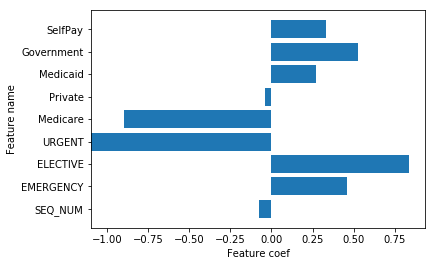

In [177]:
feature_names = list(X)
print feature_names
print clf.coef_
import numpy as np
c_features = len(feature_names)
plt.barh(range(c_features), clf.coef_[0] )
plt.xlabel("Feature coef")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), feature_names)
plt.show()

Medicare is a federal program that provides health coverage if you are 65 or older or have a severe disability, no matter your income.
Medicaid is a state and federal program that provides health coverage if you have a very low income.

### Training with random forest

In [178]:
print("Random Forest...")
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100, max_depth = 5, class_weight ='balanced') 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( X_train, y_train)

score_train_forest = forest.score(X_train, y_train)
score_test_forest = forest.score(X_test, y_test)


print('Training Accuracy: %.3f' % forest.score(X_train, y_train))
print('Test Accuracy: %.3f' % forest.score(X_test, y_test))

Random Forest...
Training Accuracy: 0.747
Test Accuracy: 0.715


In [179]:
feature_names = list(X)
print feature_names
print forest.feature_importances_

['SEQ_NUM', 'EMERGENCY', 'ELECTIVE', 'URGENT', 'Medicare', 'Private', 'Medicaid', 'Government', 'SelfPay']
[ 0.4457206   0.03012613  0.04910924  0.03862111  0.26149551  0.0755043
  0.04846716  0.03636749  0.01458846]


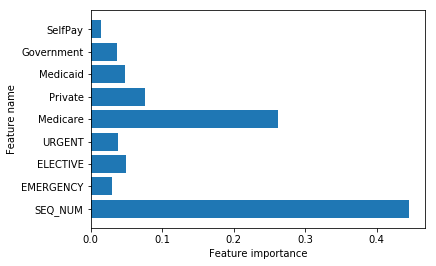

In [180]:

c_features = len(feature_names)
plt.barh(range(c_features), forest.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), feature_names)
plt.show()

## NEXT STEP
1. Generate additional features
2. binary --> multi-class classification